In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os.path as op
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import SVG
from keras import backend as K
from keras.callbacks import TensorBoard
from keras.utils.vis_utils import model_to_dot
from keras_tqdm import TQDMNotebookCallback
from tqdm import tqdm_notebook

from data import im_generator
from unet import unet

Using TensorFlow backend.


In [2]:
# print models as seen by tf
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [3]:
model = unet(input_size=(28, 28, 1), with_extra_sigmoid=False, n_layers=2)

Instructions for updating:
Colocations handled automatically by placer.


/home/zaccharie/workspace/understanding-unets/unet.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  model = Model(input=inputs, outputs=output)
/home/zaccharie/workspace/understanding-unets/venv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
model.weights

[<tf.Variable 'conv2d_1_1/kernel:0' shape=(3, 3, 1, 1) dtype=float32_ref>,
 <tf.Variable 'conv2d_1_1/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'conv2d_2_1/kernel:0' shape=(3, 3, 1, 1) dtype=float32_ref>,
 <tf.Variable 'conv2d_2_1/bias:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'conv2d_3_1/kernel:0' shape=(3, 3, 2, 1) dtype=float32_ref>,
 <tf.Variable 'conv2d_3_1/bias:0' shape=(1,) dtype=float32_ref>]

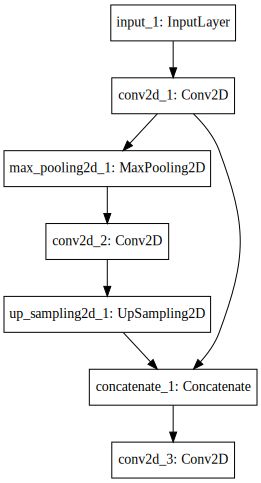

In [5]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [6]:
batch_size = 32
noise_std = 30
im_gen_train = im_generator(mode='training', validation_split=0.1, batch_size=batch_size, source='mnist', noise_std=noise_std)
im_gen_val = im_generator(mode='validation', validation_split=0.1, batch_size=batch_size, source='mnist', noise_std=noise_std)
im_gen_test = im_generator(mode='testing', batch_size=batch_size, source='mnist', noise_std=noise_std)

In [7]:
params = {
    'corrected_classic_1': {'n_layers': 2},
    'corrected_without_relu_contracting_1': {'n_layers': 2, 'non_relu_contract': True},
    'corrected_classic_2': {'n_layers': 3},
    'corrected_without_relu_contracting_2': {'n_layers': 3, 'non_relu_contract': True},
    'corrected_aver_pool_2': {'n_layers': 3, 'pool': 'average'},
}

In [8]:
val = next(im_gen_val)

In [9]:
n_epochs = 50
K.clear_session() 
for run_id, run_params in tqdm_notebook(params.items()):
    print(run_id)
    model = unet(input_size=(28, 28, 1), with_extra_sigmoid=False, **run_params)
    log_dir = op.join('logs', run_id)
    tboard_cback = TensorBoard(
        log_dir=log_dir, 
        histogram_freq=1, 
        batch_size=batch_size, 
        write_graph=True, 
        write_images=True, 
    )
    model.fit_generator(
        im_gen_train, 
        steps_per_epoch=int(0.9*5*1e4 / 32), 
        epochs=n_epochs,
        validation_data=val,
        validation_steps=int(0.1*5*1e4 / 32),
        verbose=0,
        callbacks=[TQDMNotebookCallback(), tboard_cback],
    )
    K.clear_session() 

corrected_classic_1


/home/zaccharie/workspace/understanding-unets/unet.py:106: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=Tensor("in...)`
  model = Model(input=inputs, outputs=output)
/home/zaccharie/workspace/understanding-unets/venv/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.


corrected_without_relu_contracting_1


corrected_classic_2


corrected_without_relu_contracting_2


corrected_aver_pool_2


In [10]:
run_id = str(int(time.time()))
print(run_id)
log_dir = op.join('logs', run_id)
tboard_cback = TensorBoard(
    log_dir=log_dir, 
    histogram_freq=1, 
    batch_size=batch_size, 
    write_graph=True, 
    write_images=True, 
)

1558081244


In [11]:
history = model.fit_generator(
    im_gen_train, 
    steps_per_epoch=int(0.9*5*1e4 / 32), 
    epochs=5,
    validation_data=next(im_gen_val),
    validation_steps=int(0.1*5*1e4 / 32),
#     validation_freq=2,
    verbose=0,
#     use_multiprocessing=True,
#     callbacks=[TQDMNotebookCallback(), tboard_cback],
)

InvalidArgumentError: Tensor input_1_1:0, specified in either feed_devices or fetch_devices was not found in the Graph

In [ ]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

In [ ]:
plt.figure(figsize=(9, 5))
for key, val in history.history.items():
    plt.plot(np.log(val), label=key)
plt.legend()

In [ ]:
batch_test_noisy, batch_test_gt = next(im_gen_test)

In [ ]:
batch_test_pred = model.predict(batch_test_noisy)

In [ ]:
K.eval(model.layers[-1].activation(-1e6))

In [ ]:
batch_test_pred.max()

In [ ]:
fig, axs = plt.subplots(32, 3, figsize=(14, 32*5))
for example_id in range(32):
    
    axs[example_id, 0].imshow(batch_test_gt[example_id, ..., 0], cmap='gray')
    axs[example_id, 0].set_title("original image")
    axs[example_id, 1].imshow(batch_test_noisy[example_id, ..., 0], cmap='gray')
    axs[example_id, 1].set_title("noisy image")
    axs[example_id, 2].imshow(batch_test_pred[example_id, ..., 0], cmap='gray')
    axs[example_id, 2].set_title("denoised image")